In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.utils.plotting import plot_series
from sktime.datasets import load_airline
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_total_payments = pd.read_csv("../Datasets/clean_total_payments.csv", index_col=0)
df_purchase_orders = pd.read_csv("../Datasets/clean_purchase_orders.csv", index_col=0)
df_customer = pd.read_csv("../Datasets/clean_customer.csv", index_col=0)
df_employees = pd.read_csv("../Datasets/clean_employees.csv", index_col=0)
df_inventory = pd.read_csv("../Datasets/clean_inventory.csv", index_col=0)
df_order_details = pd.read_csv("../Datasets/clean_order_details.csv", index_col=0)
df_orders = pd.read_csv("../Datasets/clean_orders.csv", index_col=0)
df_products = pd.read_csv("../Datasets/clean_products.csv", index_col=0)
df_order_payment = pd.read_csv("../Datasets/clean_order_payment.csv", index_col=0)

In [3]:
df = pd.merge(df_order_details, df_orders, on = 'OrderID')
df = pd.merge(df, df_products, on = 'ProductID')
df.head()

,OrderDetailID,OrderID,ProductID,QuantitySold,UnitSalesPrice,total_price,CustomerID,EmployeeID,ShippingMethodID,OrderDate,...,Category,Gender,ProductLine,Weight,Size,PackSize,Status,InventoryDate,PurchasePrice,ProductType
0,2,2,955,5,7.5,37.5,1,1,1,2003-07-10,...,Drawers,Women's Panties,Underwear,997,XXL,Dozen,In Production,2003-07-10,7.15,PCL29
1,3,2,958,5,8.5,42.5,1,1,1,2003-07-10,...,Drawers,Women's Panties,Underwear,1110,XXL,Dozen,In Production,2003-07-10,8.30,PCL31S
2,5,2,959,5,8.5,42.5,1,1,1,2003-07-10,...,Drawers,Women's Panties,Underwear,1055,XXL,Dozen,In Production,2003-07-10,7.20,PCL31T
3,6,4,72,50,3.0,150.0,2,2,1,2003-07-11,...,Briefs,Boys' Briefs,Underwear,233,S,Dozen,In Production,2003-07-10,2.50,ERK61
4,7,4,9,50,3.2,160.0,2,2,1,2003-07-11,...,Briefs,Boys' Briefs,Underwear,325,M,Dozen,In Production,2003-07-10,2.70,ERK61


In [4]:
# Convert date to datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

df.dtypes

OrderDetailID                int64
OrderID                      int64
ProductID                    int64
QuantitySold                 int64
UnitSalesPrice             float64
total_price                float64
CustomerID                   int64
EmployeeID                   int64
ShippingMethodID             int64
OrderDate           datetime64[ns]
ShipDate                    object
FreightCharge              float64
DeliveryTime                 int64
OrderYear                    int64
OrderMonth                   int64
ProductName                 object
ModelDescription            object
Category                    object
Gender                      object
ProductLine                 object
Weight                       int64
Size                        object
PackSize                    object
Status                      object
InventoryDate               object
PurchasePrice              float64
ProductType                 object
dtype: object

In [5]:
sales = df.groupby(['OrderDate'])['QuantitySold'].sum().reset_index()
sales

,OrderDate,QuantitySold
0,2003-07-10,145
1,2003-07-11,330
2,2003-07-14,768
3,2003-07-15,835
4,2003-07-16,540
...,...,...
741,2006-04-13,2044
742,2006-04-14,92
743,2006-04-18,147
744,2006-04-19,4145


In [6]:
sales.isna().sum()

OrderDate       0
QuantitySold    0
dtype: int64

In [7]:
sales = sales.set_index('OrderDate')
sales = sales.asfreq('W-MON')

#Interpolacion de los valores faltantes
sales['QuantitySold'] = sales['QuantitySold'].interpolate()
sales

,QuantitySold
OrderDate,
2003-07-14,768.0
2003-07-21,180.0
2003-07-28,614.0
2003-08-04,573.0
2003-08-11,375.0
...,...
2006-03-20,46.0
2006-03-27,25.0
2006-04-03,1080.0


In [8]:
y = sales

In [9]:
y.isna().sum()

QuantitySold    0
dtype: int64

In [10]:
mean_value = sales['QuantitySold'].mean()
mean_value

np.float64(1004.5068965517241)

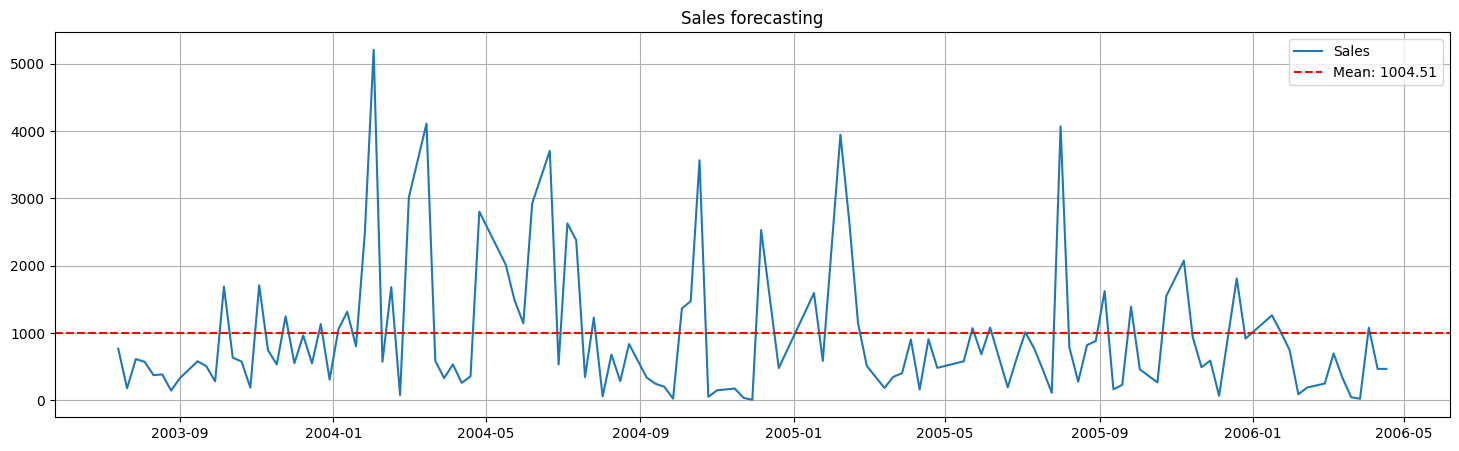

In [11]:
plt.figure(figsize=(18,5))
plt.plot(y, linestyle="-", label = 'Sales')
plt.axhline(y=mean_value, color='r', linestyle="--", label=f"Mean: {mean_value:.2f}")
plt.title('Sales forecasting')
plt.legend()
plt.grid()
plt.show()


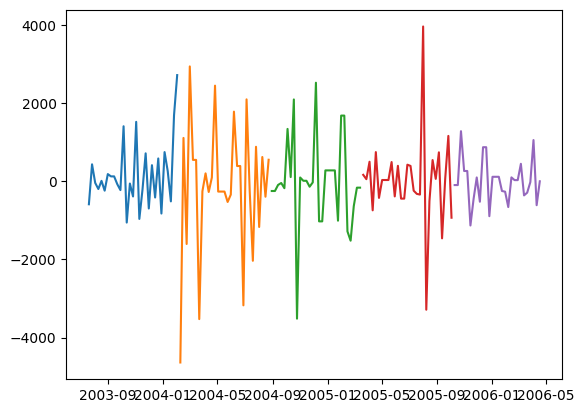

In [12]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

non_stationary_series = y.diff().dropna()

slog1, slog2, slog3, slog4, slog5 = list(split(non_stationary_series, 5))
plt.plot(slog1)
plt.plot(slog2)
plt.plot(slog3)
plt.plot(slog4)
plt.plot(slog5)
plt.show()

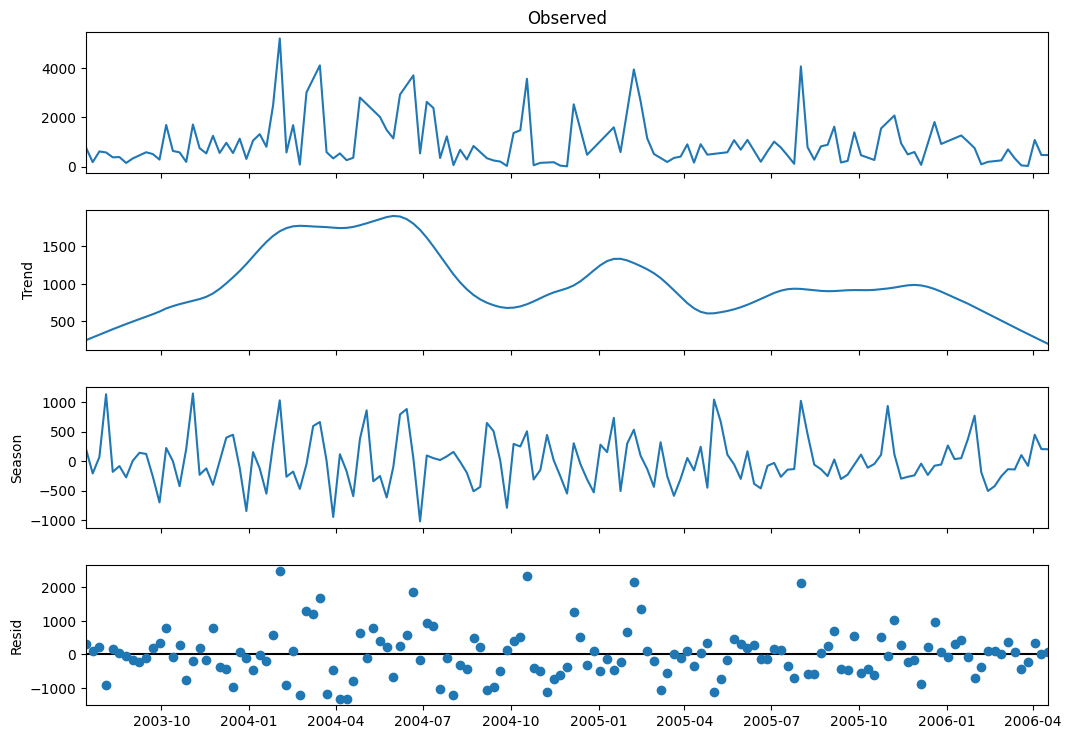

In [13]:
stl = STL(y, period = 13, seasonal = 7)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(12, 8)

In [14]:
res = stats.levene(slog1, slog2, slog3, slog4, slog5)
print('P-valor:', res.pvalue)

P-valor: [0.01927218]


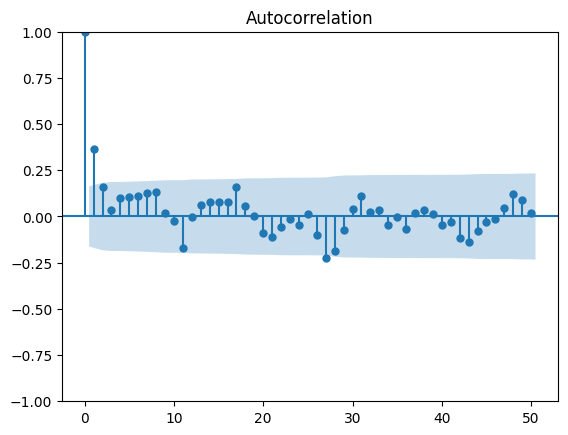

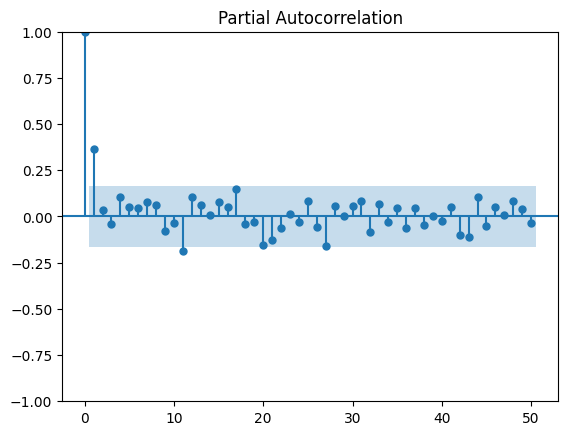

AttributeError: 'LeveneResult' object has no attribute 'resid'

In [15]:
plot_acf(y, lags=50)
plt.show()
plot_pacf(y, lags=50)
plt.show()

fig, ax = plot_series(res.resid) 
plot_acf(res.resid, lags=50)
plt.show()
plot_pacf(res.resid, lags=50)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF: Augmented Dickey-Fuller Test. P-valor mayor que el alpha --> hay que diferenciar. Si es más bajo --> no hay que diferenciar
print("Augmented Dickey-Fuller serie: ",adfuller(y)[1])
print("Augmented Dickey-Fuller residuos: ",adfuller(res.resid)[1])

print("")

# KPSS: Kwiatkowski-Phillips-Schmidt-Shin Test. P-valor mayor que el alpha --> no hay que diferenciar. Si es más bajo --> hay que diferenciar
print("KPSS Test serie, pvalor es: ",kpss(y)[1])
print("KPSS Test residuos, pvalor es: ",kpss(res.resid)[1])

Augmented Dickey-Fuller serie:  1.3517280752951798e-06
Augmented Dickey-Fuller residuos:  3.087372582287012e-20

KPSS Test serie, pvalor es:  0.03719104979176695
KPSS Test residuos, pvalor es:  0.1


In [ ]:
from sklearn.metrics import mean_squared_error

def mae(y, y_hat):
    return np.mean(np.abs(y - y_hat))

def rmse(y, y_hat):
    return np.sqrt(mean_squared_error(y, y_hat))

def nrmse (y, y_hat):
    return rmse(y, y_hat) / np.std(y)

def mape(y, y_hat):
    return np.mean(np.abs(y - y_hat) / y) * 100

In [ ]:
### ## ## ##
def optimizaARIMA(data,P =3, D = 1, Q = 3, debug = False):
    p_values = range(0, P+1)
    d_values = range(0, D+1)
    q_values = range(0, Q+1)
    minNRMSE = 10e30
    AICmin, AICCmin, BICmin = 10e30, 10e30, 10e30
    min_order = (0,0,0)
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                warnings.filterwarnings("ignore")
                try:
                    model = ARIMA(data, order=order).fit()
                    predictions = model.fittedvalues
                    NRMSE = nrmse (data, predictions)
                    RMSE = rmse(data, predictions)
                    MAE = mae(data, predictions)
                    MAPE = mape(data, predictions)  
                    AIC, AICC, BIC = model.aic, model.aicc, model.bic
                    print('ARIMA%s NRMSE=%.3f, AIC=%.3f, AICC=%.3f, BIC=%.3f' % (order,NRMSE, AIC, AICC, BIC))
                    if AICCmin > AICC:
                        minNRMSE = NRMSE
                        min_order = order
                        AICmin, AICCmin, BICmin = model.aic, model.aicc, model.bic
                        RMSEmin, MAEmin, MAPmin = RMSE, MAE, MAPE
                except:
                    print('ARIMA%s NO EJECUTABLE' % (order))
    
    print('Best ARIMA%s NRMSE=%.3f, AIC=%.3f, AICC=%.3f, BIC=%.3f' % (min_order,minNRMSE,AICmin	, AICCmin, BICmin))
    model = ARIMA(data, order=min_order).fit()

    return model, min_order, (minNRMSE, AICmin, AICCmin, BICmin, RMSEmin, MAEmin, MAPmin)

ARIMA(0, 0, 0) NRMSE=1.000, AIC=12232.915, AICC=12232.932, BIC=12242.109
ARIMA(0, 0, 1) NRMSE=1.000, AIC=12234.923, AICC=12234.956, BIC=12248.714
ARIMA(0, 0, 2) NRMSE=1.000, AIC=12236.926, AICC=12236.981, BIC=12255.314
ARIMA(0, 0, 3) NRMSE=1.000, AIC=12238.503, AICC=12238.586, BIC=12261.489
ARIMA(0, 1, 0) NRMSE=1.414, AIC=12722.487, AICC=12722.493, BIC=12727.083
ARIMA(0, 1, 1) NRMSE=1.003, AIC=12223.780, AICC=12223.796, BIC=12232.971
ARIMA(0, 1, 2) NRMSE=1.003, AIC=12225.773, AICC=12225.806, BIC=12239.560
ARIMA(0, 1, 3) NRMSE=1.002, AIC=12226.234, AICC=12226.289, BIC=12244.617
ARIMA(1, 0, 0) NRMSE=1.000, AIC=12234.915, AICC=12234.948, BIC=12248.706
ARIMA(1, 0, 1) NRMSE=1.000, AIC=12236.921, AICC=12236.976, BIC=12255.310
ARIMA(1, 0, 2) NRMSE=0.998, AIC=12235.803, AICC=12235.885, BIC=12258.788
ARIMA(1, 0, 3) NRMSE=0.997, AIC=12236.881, AICC=12236.997, BIC=12264.464
ARIMA(1, 1, 0) NRMSE=1.226, AIC=12515.912, AICC=12515.928, BIC=12525.103
ARIMA(1, 1, 1) NRMSE=1.003, AIC=12225.776, AICC=122

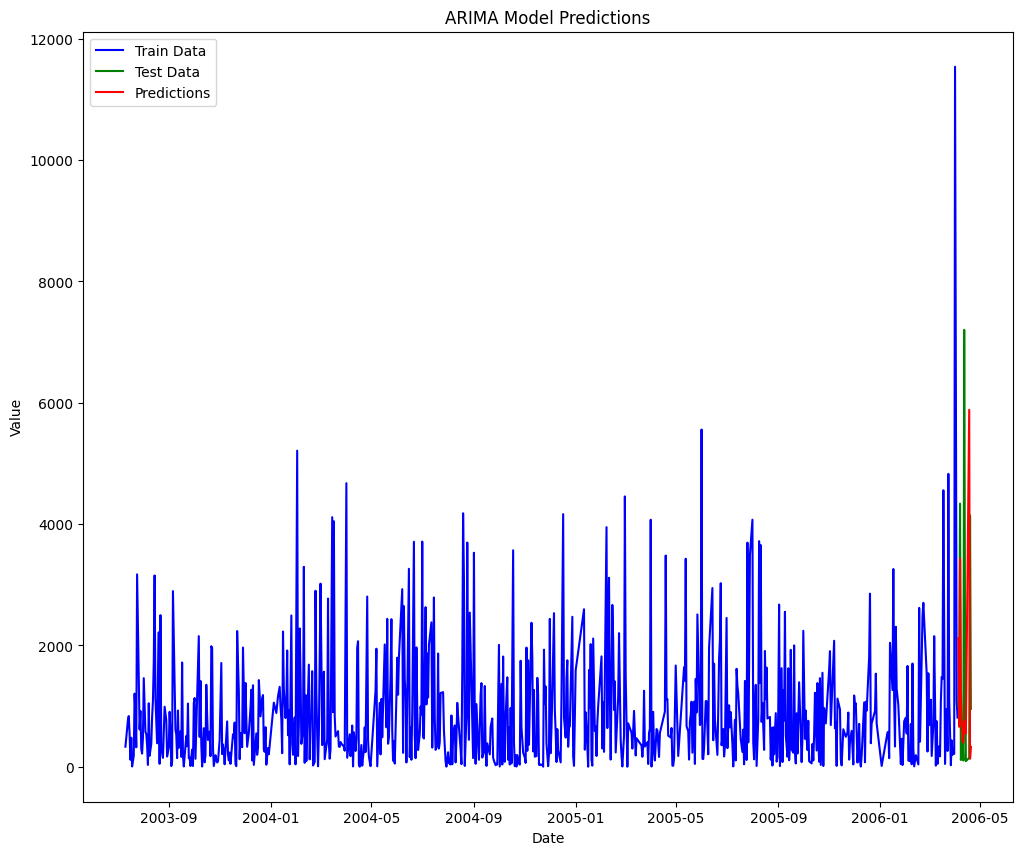

Error final NRMSE es de:  1.3186104631917897
RMSE 2843.605782
STD 2156.516926


In [ ]:
train_data_orig = y[1:len(y)-12]
test_data_orig = y[len(y)-12:]

model, min_order,(minNRMSE,AICmin, AICCmin, BICmin, RMSEmin, MAEmin, MAPmin) = optimizaARIMA(train_data_orig)

stlf = STLForecast(train_data_orig, ARIMA, model_kwargs={"order": min_order, "trend": 't'}, period = 12, seasonal=13)
res = stlf.fit()
predictions = res.forecast(12)

plt.figure(figsize=(12, 10))
plt.plot(train_data_orig.index, train_data_orig.values, color='blue', label='Train Data')
plt.plot(test_data_orig.index, test_data_orig.values, color='green', label='Test Data')
plt.plot(test_data_orig.index, predictions  , color='red', label='Predictions')

plt.legend()
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Value')

plt.show()

print("Error final NRMSE es de: ", nrmse(test_data_orig.values, predictions))
print('RMSE %3f' % (rmse(test_data_orig.values, predictions)))
print('STD %3f' % (np.std(test_data_orig.values)))

In [ ]:
def optimizaSARIMA(data,P = 2, D = 1, Q = 2, PS = 1, DS = 1, QS = 1, m = 12, debug = False):
    p_values = range(0, P+1)
    d_values = range(0, D+1)
    q_values = range(0, Q+1)
    ps_values = range(0, PS+1)
    ds_values = range(0, DS+1)
    qs_values = range(0, QS+1)
    minNRMSE = 10e30
    AICmin, AICCmin, BICmin = 10e30, 10e30, 10e30
    min_order = (0,0,0)
    min_orderS = (0,0,0,m)

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for ps in ps_values:
                    for ds in ds_values:
                        for qs in qs_values:
                            order = (p,d,q)
                            orderS = (ps,ds,qs,m)
                            warnings.filterwarnings("ignore")
                            try:
                                model = SARIMAX(data, order=order, seasonal_order=orderS).fit(disp=0)
                                predictions = model.fittedvalues
                                NRMSE = nrmse (data, predictions)
                                AIC, AICC, BIC = model.aic, model.aicc, model.bic
                                
                                print('SARIMA%s,%s NRMSE=%.3f, AIC=%.3f, AICC=%.3f, BIC=%.3f' % (order,orderS,NRMSE, AIC, AICC, BIC))
                                if AICCmin > AICC:
                                    minNRMSE = NRMSE
                                    min_order = order
                                    min_orderS = orderS
                                    AICmin, AICCmin, BICmin = model.aic, model.aicc, model.bic
                            except:
                                print('SARIMA%s,%s NO EJECUTABLE' % (order, orderS))

    
    print('Best SARIMA%s,%s NRMSE=%.3f, AIC=%.3f, AICC=%.3f, BIC=%.3f' % (min_order,min_orderS, minNRMSE,AICmin	, AICCmin, BICmin))
    model = SARIMAX(data, order=min_order, seasonal_order=min_orderS).fit(disp=0)
    return model, min_order, min_orderS, (minNRMSE, AICmin, AICCmin, BICmin)

SARIMA(0, 0, 0),(0, 0, 0, 12) NRMSE=1.377, AIC=11909.663, AICC=11909.668, BIC=11914.206


SARIMA(0, 0, 0),(0, 0, 1, 12) NRMSE=1.241, AIC=11767.833, AICC=11767.850, BIC=11776.921
SARIMA(0, 0, 0),(0, 1, 0, 12) NRMSE=1.336, AIC=11665.951, AICC=11665.957, BIC=11670.477
SARIMA(0, 0, 0),(0, 1, 1, 12) NRMSE=1.037, AIC=11321.062, AICC=11321.080, BIC=11330.115
SARIMA(0, 0, 0),(1, 0, 0, 12) NRMSE=1.170, AIC=11685.717, AICC=11685.734, BIC=11694.804
SARIMA(0, 0, 0),(1, 0, 1, 12) NRMSE=1.037, AIC=11523.931, AICC=11523.965, BIC=11537.562
SARIMA(0, 0, 0),(1, 1, 0, 12) NRMSE=1.199, AIC=11517.742, AICC=11517.760, BIC=11526.795
SARIMA(0, 0, 0),(1, 1, 1, 12) NRMSE=1.030, AIC=11313.281, AICC=11313.317, BIC=11326.861
SARIMA(0, 0, 1),(0, 0, 0, 12) NRMSE=1.273, AIC=11803.367, AICC=11803.384, BIC=11812.455
SARIMA(0, 0, 1),(0, 0, 1, 12) NRMSE=1.195, AIC=11716.897, AICC=11716.932, BIC=11730.529
SARIMA(0, 0, 1),(0, 1, 0, 12) NRMSE=1.336, AIC=11667.646, AICC=11667.664, BIC=11676.699
SARIMA(0, 0, 1),(0, 1, 1, 12) NRMSE=1.037, AIC=11322.964, AICC=11323.000, BIC=11336.544
SARIMA(0, 0, 1),(1, 0, 0, 12) NR

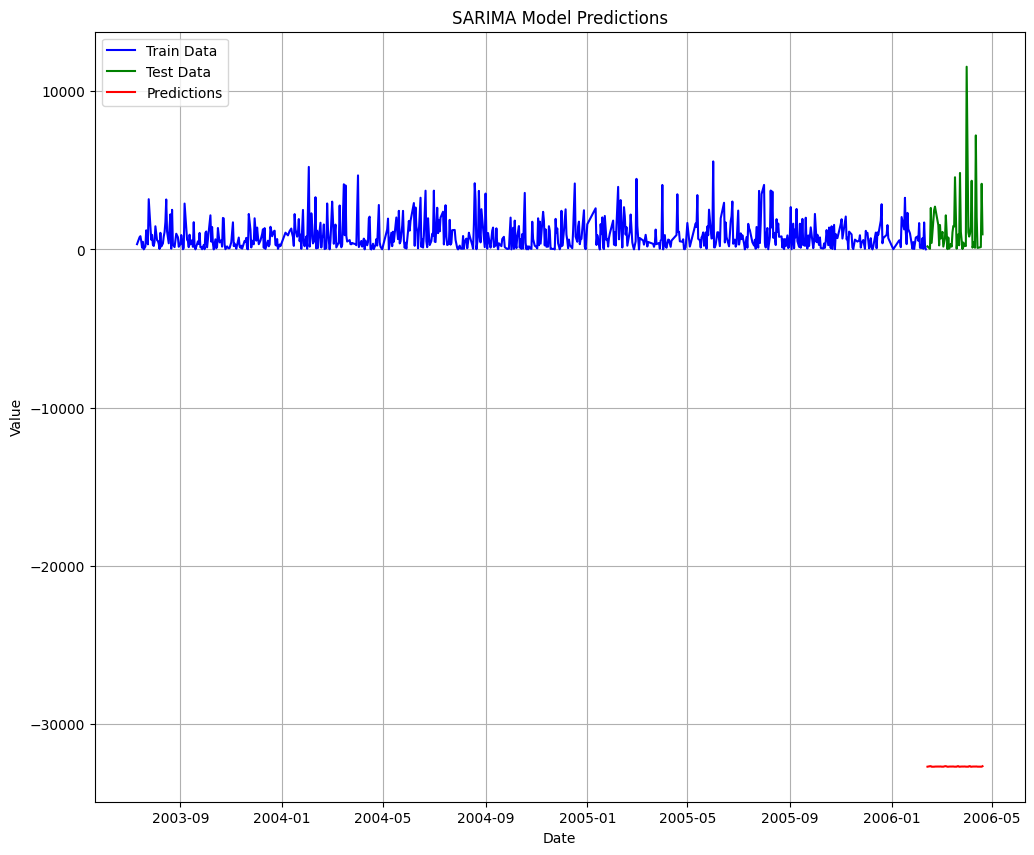

Error final NRMSE es de:  16.50299834586188
RMSE 34164.860270
STD 2070.221396


In [ ]:
train_data_orig = y[1:len(y)-50]
test_data_orig = y[len(y)-50:]

model, min_order, min_orderS,(minNRMSE,AICmin, AICCmin, BICmin) = optimizaSARIMA(train_data_orig)

predictions = model.predict(start=len(train_data_orig), end=len(train_data_orig) + len(test_data_orig)-1)
plt.figure(figsize=(12, 10))
plt.plot(train_data_orig.index, train_data_orig.values, color='blue', label='Train Data')
plt.plot(test_data_orig.index, test_data_orig.values, color='green', label='Test Data')
plt.plot(test_data_orig.index, predictions  , color='red', label='Predictions')

plt.legend()
plt.title('SARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid()

plt.show()

print("Error final NRMSE es de: ", nrmse(test_data_orig.values, predictions))
print('RMSE %3f' % (rmse(test_data_orig.values, predictions)))
print('STD %3f' % (np.std(test_data_orig.values)))

In [ ]:
train_data_orig = y[1:len(y)-50]
test_data_orig = y[len(y)-50:]

model = ExponentialSmoothing(train_data_orig,  trend='add', damped_trend=False, seasonal = 'add', seasonal_periods=12).fit()
predictions = model.predict(start=len(train_data_orig), end=len(train_data_orig) + len(test_data_orig)-1)

plt.figure(figsize=(12, 10))
plt.plot(train_data_orig.index, train_data_orig.values, color='blue', label='Train Data')
plt.plot(test_data_orig.index, test_data_orig.values, color='green', label='Test Data')
plt.plot(test_data_orig.index, predictions  , color='red', label='Predictions')

# Añadir leyendas y título
plt.legend()
plt.title('Holt Winters')
plt.xlabel('Date')
plt.ylabel('Value')

# Mostrar la gráfica
plt.show()

print("Error final NRMSE es de: ", nrmse(test_data_orig.values, predictions))
print('RMSE %3f' % (rmse(test_data_orig.values, predictions)))
print('STD %3f' % (np.std(test_data_orig.values)))